# Laboratorium 9

### 0. Wczytanie danych
Używając metody `load_svmlight_file` z modułu `sklearn` załaduj plik `lab13_files/breast_cancer`, który składa się z 2 elementów: macierzy `X` o wymiarach `683 x 10` oraz wektora `y` o dlugosci `683`. Macierz `X` opisuje badania 683 pacjentow, a wektor `y` ich diagnozy. 

In [1]:
import pylab as pl
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

X, y = load_svmlight_file('lab13_files/breast-cancer')
X = X.toarray()

X,X_test, y, y_test = train_test_split(X,y,train_size=0.8,random_state=32)
print(f"{X.shape=}")
print(f"{len(y)=}")


X.shape=(546, 10)
len(y)=546


### 1. Preprocessing
1.1 Korzystajac z `numpy.where` przenumeruj wektor y, tzn zamień wartości 2 i 4 na -1 i +1. 

1.2 Przeskaluj macierz X, tak żeby wartości w każdej kolumnie mieściły się w zakresie [0,1], innymi słowy przeskaluj niezależnie każdą kolumne $X_j$ wg wzoru:


$$
X_j = \frac{X_j-\min(X_j)}{\max(X_j)-\min(X_j)}
$$

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
import numpy as np

y = np.where(y == 2, -1,  np.where(y == 4, 1, y))


In [4]:
y_test = np.where(y_test == 2, -1,  np.where(y_test == 4, 1, y_test))

X_test = scaler.transform(X_test)

### 2. Wizualizacja
Narysuj dane używajac biblioteki `matplotlib`. Użyj wymiarów 1 i 2 z macierzy X, a jako kolory użyj wektora y. Pobaw sie parametrami "s" oraz "alpha" metody `plt.scatter` żeby uzyskać czytelną wizualizacje, np. taką jak poniżej.

<img src="lab13_files/d.png">

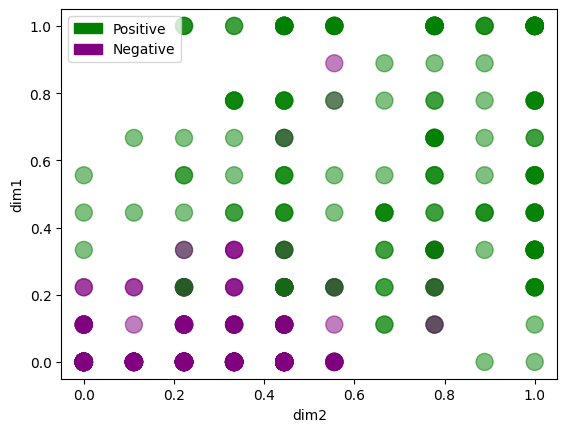

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

x_dim1 = X_scaled[:, 1]
x_dim2 = X_scaled[:, 2]
colors = np.where(y == -1, 'purple', 'green')
plt.scatter(x_dim1, x_dim2, c=colors, s = 150 , alpha=0.5)

plt.xlabel("dim2")
plt.ylabel("dim1")

green_patch = mpatches.Patch(color='green', label='Positive')
purple_patch = mpatches.Patch(color='purple', label='Negative')
plt.legend(handles=[green_patch, purple_patch])



plt.show()

### 3. Regresja 

Przeprowadź regresje liniową wg wzoru:
$$
\beta = (X^TX)^{-1}X^Ty
$$

In [6]:
X_b = np.c_[np.ones((X.shape[0], 1)), X]
beta = np.linalg.inv(X_b.T @ X_b)@X_b.T@y

### 4. Wizualizacja Regresji

Zwizualizuj dane po zrzutowaniu na $\beta$ używajac metody `plt.hist`, tzn. narysuj histogramy $\beta X_+$ oraz
$\beta X_-$ gdzie $X_+$ to wiersze $X$ dla których $y=+1$ i analogicznie $X_-$. Postaraj się wygenerować czytelny wykres podobny do tego poniżej.

<img src="lab13_files/lr1.png">

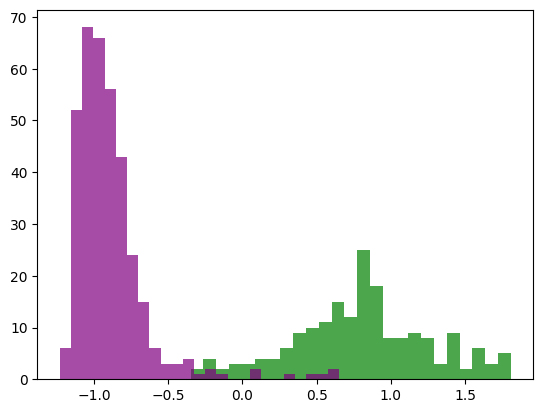

In [7]:
X_p = X_b[y==1]
X_m = X_b[y==-1]

beta_X_p = np.dot(X_p, beta)
beta_X_m = np.dot(X_m, beta)

plt.hist(beta_X_p, bins=25, alpha=0.7, label=r'beta X+', color="green")
plt.hist(beta_X_m, bins=25, alpha=0.7, label=r'beta X-', color="purple")


plt.show()

### 5. Klasyfikacja

Przeprowadź "klasyfikacje" naszych pacjentów, ci, którzy zostali zrzutowani na wartość ujemną dostają etykiete $-1$, a ci którzy na wartość dodatnia - etykiete $+1$

In [8]:
classification = np.dot(X_b,beta)

prediction=np.where(classification <= 0, -1,1)

### 6. Ewaluacja

Policz jak dokładny jest ten model, tzn. jak duży jest zbiór
$ \{ (x_i,y_i) : \mathrm{sign}(\beta x_i) = y_i \} $
w stosunku do rozmiaru całego $y$

Powinno udać się uzyskać wynik na poziomie 93-94%

In [9]:
prop_pred = len(prediction[prediction==y])
print(prop_pred/len(y))

0.967032967032967


### 7. Regularyzacja 
Dodaj parametr `C` do regresji liniowej
$$
\beta = (X^TX + \tfrac{1}{C}I)^{-1}X^Ty
$$

gdzie $I$ - macierz identyczności. 

Dla jakiej wartości `C` wynik jest najlepszy? Jaki wynik udało Ci sie uzyskać?

In [10]:
def find_c(start, end,*,X,y,amount=5):
    c_list = np.linspace(start,end,amount)
    predictions = []
    for c in c_list:
        diag = np.diag([1/c] * 11)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        beta = np.linalg.inv(X_b.T @ X_b + diag) @ X_b.T @ y
        
        classification = np.dot(X_b,beta)
        
        prediction=np.where(classification <= 0, -1,1)
        prediction_score = len(prediction[prediction==y])/len(y)
        predictions.append(prediction_score)
        
    predictions = np.array(predictions)
    max_c = c_list[predictions.argmax()]
    return max_c, predictions.max()

c, percent = find_c(0.000001,1,X=X_scaled,y=y, amount=200)    
print(c, percent)

1e-06 0.9688644688644689


In [11]:
beta.min(),beta.max()

(-1.4864455385018158, 0.10010791485920584)

### 8. Gratulacje
Właśnie stworzyłeś/-aś swój pierwszy klasyfikator (statystyczny model predykcji). 

Spróbuj zastosować go do innych danych.

In [12]:
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
classification = np.dot(X_test,beta)

prediction=np.where(classification < 0, -1, 1)

prop_pred = len(prediction[prediction==y_test])
print(prop_pred/len(y_test))

0.635036496350365


### Zadanie dodatkowe

Zaimplementuj powyższą metode jako klase `LRClassifier` wyposażoną w następujące metody:

* konstruktor przyjmujący dwa parametry: 
    * `C` - stała z równania 
    * `scale` - zmienna boolowska (domyslnie `True`) która określa czy macierz `X` ma byc automatycznie znormalizowana (przeskalowana do `[0,1]`)
* `.fit(X, y)` która spowoduje obliczenie $\beta$, dla `X` - dowolnej macierzy, `y` - wektora etykiet skladajacego sie z dwóch unikalnych wartosci (mogą to byc np. 2 różne stringi)
* `.predict(X)`, która zwróci wektor zawierajacy na `i`tej pozycji etykiete "przewidzianą" przez nasz model (pamiętaj o skalowaniu jesli `scale==True`!)

Przykladowe użycie:

    clf = LRClassifier(C=100)
    Xt = np.array([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4]])
    yt = np.array(['x', 'x', 'y', 'y', 'y'])
    clf.fit(Xt, yt)
    X = np.array([[1, -1], [1, 0.9], [1, 2.1]])
    print(clf.predict(X)) # ['x', 'x', 'y']

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class LRClassifier:
    
    def __init__(self,*,C,scale=True):
        self.c = C
        self.scale=scale
        self.output_dict = {}
        self.beta = 0
        if(scale):
            self.scaler = MinMaxScaler()
        
    def rescale(self,X):
        return self.scaler.fit_transform(X)

    def redefine_y_values(self,y):
        temp = np.unique(y)
        self.output_dict[-1] = temp[0]
        self.output_dict[1] = temp[1]
        return np.where(y == temp[0], -1, 1)
    
    def fit(self, X,y):
        if self.scale:
            X = self.scaler.fit_transform(X)

        y = self.redefine_y_values(y)
        
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        diag = np.diag([1/self.c] * X_b.shape[1])

        self.beta = np.linalg.inv(X_b.T @ X_b + diag)@X_b.T@y
    
    def predict(self,X):
        if self.scale:
            X = self.scaler.transform(X)
        print(X)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        classification = np.dot(X_b, self.beta)
        print(classification)
        prediction=np.where(classification <= 0, -1,1)

        return np.array([self.output_dict[x] for x in prediction])

clf = LRClassifier(C=100)
Xt = np.array([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4]])
yt = np.array(['x', 'x', 'y', 'y', 'y'])
clf.fit(Xt, yt)
X = np.array([[1, -1], [1, 0.9], [1, 2.1]])
print(clf.predict(X)) # ['x', 'x', 'y']

[[ 0.    -0.25 ]
 [ 0.     0.225]
 [ 0.     0.525]]
[-1.5639432  -0.44554378  0.26081375]
['x' 'x' 'y']
